In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

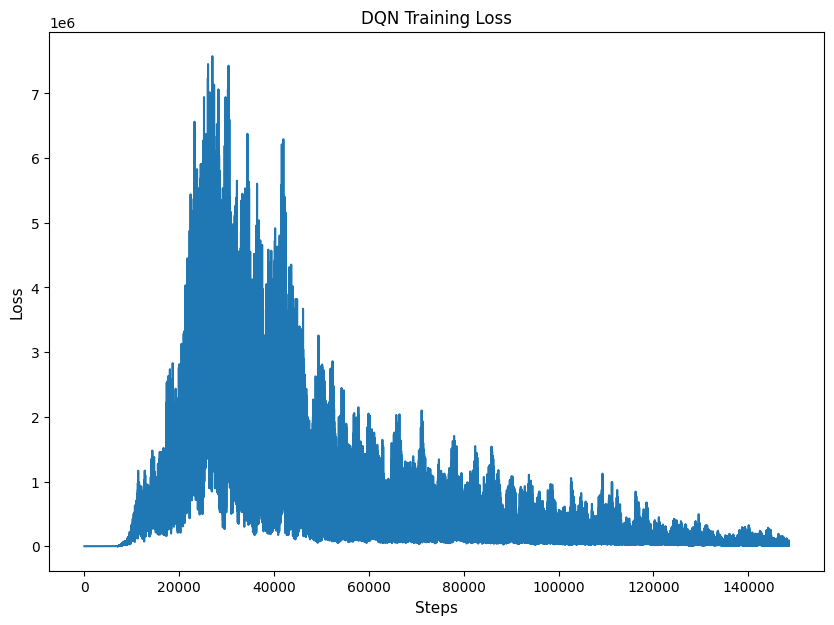

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from Gridworld import Gridworld

# 1. Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.cat(state),
            torch.tensor(action, dtype=torch.long),
            torch.tensor(reward, dtype=torch.float32),
            torch.cat(next_state),
            torch.tensor(done, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

# 2. DQN Model
class DQNNet(nn.Module):
    def __init__(self, state_dim=64, action_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    def forward(self, x):
        return self.net(x)

# 3. LightningModule
class DQNLitModule(LightningModule):
    def __init__(self, state_dim=64, action_dim=4, gamma=0.99, lr=1e-3, device='cpu'):
        super().__init__()
        self.model = DQNNet(state_dim, action_dim).to(device)
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma
        self.lr = lr
        self.device_for_tensor = device

    def training_step(self, batch, batch_idx):
        state, action, reward, next_state, done = batch
        q_values = self.model(state)
        q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            q_next = self.model(next_state).max(1)[0]
            expected_q = reward + self.gamma * q_next * (1 - done)
        loss = self.loss_fn(q_value, expected_q)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

# 4. 環境互動與訓練流程
class DQNTrainer:
    def __init__(
        self, epochs=5000, batch_size=200, buffer_size=1000, epsilon_start=1.0, epsilon_min=0.1,
        epsilon_decay=None, gamma=0.99, lr=1e-3, max_moves=50, device="cpu"
    ):
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer = ReplayBuffer(buffer_size)
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = (epsilon_start - epsilon_min) / epochs if epsilon_decay is None else epsilon_decay
        self.gamma = gamma
        self.lr = lr
        self.max_moves = max_moves
        self.device = device

        self.model = DQNLitModule(gamma=gamma, lr=lr, device=device)
        self.losses = []

    def state_transform(self, board_np):
        state = board_np.reshape(1, 64) + np.random.rand(1, 64) / 100.0
        return torch.from_numpy(state).float().to(self.device)

    def train_loop(self):
        # 初始化 optimizer
      optimizer = self.model.configure_optimizers()
      action_set = ['u', 'd', 'l', 'r']   # 加在這裡
      for i in range(self.epochs):
          env = Gridworld(size=4, mode='random')
          state = self.state_transform(env.board.render_np())
          status, moves = 1, 0
          while status == 1:
              moves += 1
              with torch.no_grad():
                  qvals = self.model.model(state)
                  qvals_np = qvals.cpu().numpy()
              if random.random() < self.epsilon:
                  action_idx = np.random.randint(0, 4)
              else:
                  action_idx = np.argmax(qvals_np)
              action = action_set[action_idx]
              env.makeMove(action)
              next_state = self.state_transform(env.board.render_np())
              reward = env.reward()
              done = True if reward != -1 else False
              self.buffer.push(state, action_idx, reward, next_state, done)
              state = next_state

              if len(self.buffer) > self.batch_size:
                  state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.buffer.sample(self.batch_size)
                  # 全部 to self.device
                  state_batch = state_batch.to(self.device)
                  action_batch = action_batch.to(self.device)
                  reward_batch = reward_batch.to(self.device)
                  next_state_batch = next_state_batch.to(self.device)
                  done_batch = done_batch.to(self.device)

                  q_values = self.model.model(state_batch)
                  q_value = q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)
                  with torch.no_grad():
                      q_next = self.model.model(next_state_batch).max(1)[0]
                      expected_q = reward_batch + self.gamma * q_next * (1 - done_batch)
                  loss = self.model.loss_fn(q_value, expected_q)

                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()
                  self.losses.append(loss.item())
              if abs(reward) == 10 or moves > self.max_moves:
                  status = 0
          if self.epsilon > self.epsilon_min:
              self.epsilon -= self.epsilon_decay

    def plot_losses(self):
        plt.figure(figsize=(10, 7))
        plt.plot(self.losses)
        plt.xlabel("Steps", fontsize=11)
        plt.ylabel("Loss", fontsize=11)
        plt.title("DQN Training Loss")
        plt.show()

# 5. 執行訓練
if __name__ == "__main__":
    trainer = DQNTrainer(device="cuda" if torch.cuda.is_available() else "cpu")
    trainer.train_loop()
    trainer.plot_losses()